In [3]:
from __future__ import print_function
import numpy as np
import PIL.Image as Image
import cv2
import pandas as pd
from skimage.filters import sobel_h, sobel_v
from skimage.feature import daisy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import seaborn as sns

In [4]:
file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
file_path_2 = '/users/jamesthomas/MachineLearning_Python/Lab2/'

df = pd.read_csv(file_path_2+'male_PA_single_disease.csv')
new_df = df[['Image Index','Finding Labels']]
new_df.groupby(['Finding Labels'])

Gabor filters feature extraction

In [5]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
            

def compute_gabor(image_name, kernels):
    file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
    img = Image.open(file_path+image_name)
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(img, kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
    
    return feats.reshape(-1)

In [6]:
'''
calculating gabor stats of each image and store them in a list named gabor_stats
'''
cnt = 0
gabor_stats = []
start_time = time.time()
for image_name in new_df['Image Index'].values:
    gabor_stats += [compute_gabor(image_name, kernels)]
    cnt += 1
    if cnt % 10 == 0:
        clear_output()
        print('{} % done! {:2f}s cost!'.format(cnt/len(new_df['Image Index'].values)*100,time.time()-start_time))

99.8719590268886 % done! 562.393195s cost!


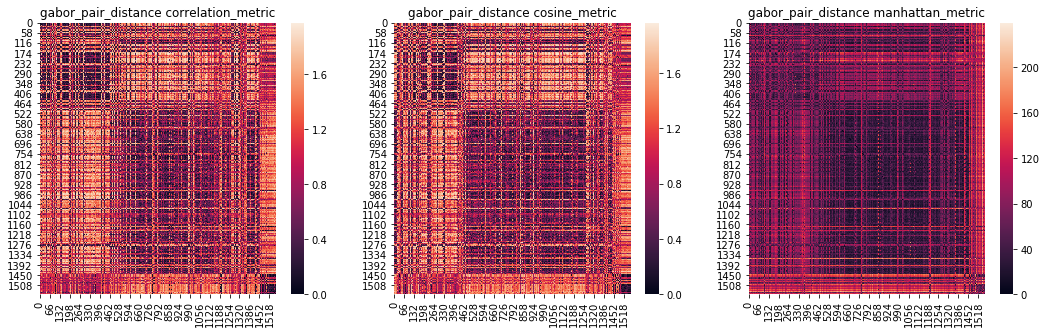

In [13]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

std = StandardScaler()


gabor_df = pd.DataFrame(np.array(gabor_stats))

gabor_pair_distance_1 = pairwise_distances(std.fit_transform(gabor_df.values), metric='correlation')
gabor_pair_distance_2 = pairwise_distances(std.fit_transform(gabor_df.values), metric='cosine')
gabor_pair_distance_3 = pairwise_distances(std.fit_transform(gabor_df.values), metric='manhattan')


fig = plt.figure(figsize = (18,5))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title('gabor_pair_distance correlation_metric')
sns.heatmap(gabor_pair_distance_1, annot=False, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('gabor_pair_distance cosine_metric')
sns.heatmap(gabor_pair_distance_2, annot=False, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('gabor_pair_distance manhattan_metric')
sns.heatmap(gabor_pair_distance_3, annot=False, ax=ax3)

plt.show()

In the heatmap, I'm using several metrics (correlation, cosine, manhattan), and the results are quite similar. Since the pictures are already grouped by its label. We can see in the heatmap, the largest block in the middle is for the label 'No Findings'. Hence, using gabor stats to classify if there is desease might be promising, and its clear that to differentiate desease types wont work on gabor stats.

Daisy feature extractor

CPU times: user 856 ms, sys: 48.2 ms, total: 904 ms
Wall time: 904 ms


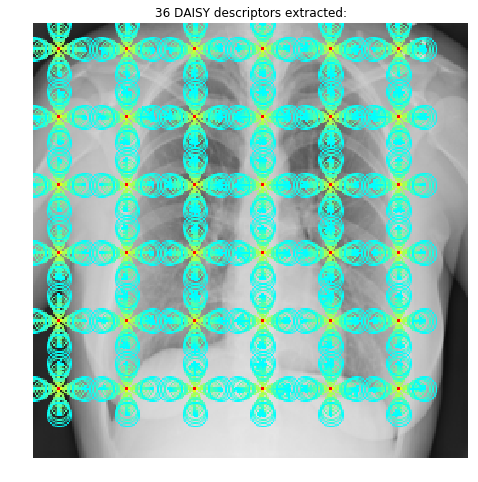

In [414]:
img = Image.open(file_path+'00005845_002.png')
%time descs, descs_img = daisy(img, visualize=True,step = 40,radius = 15, rings = 10,histograms = 4, orientations = 8)
descs_num = descs.shape[0] * descs.shape[1]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(descs_img)
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

In [17]:
def get_daisy_vec(image_name):
    file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
    img = Image.open(file_path+image_name)
    descs, descs_img = daisy(img, visualize=True,step = 40,radius = 15, rings = 10,histograms = 4, orientations = 8)
    descs_num = descs.shape[0] * descs.shape[1]
    return np.reshape(descs,(descs_num,descs.shape[2]))

In [18]:
get_daisy_vec('00007285_004.png').shape

(36, 328)

In [21]:
cnt = 0
daisy_vec_list = []
start_time = time.time()
for image_name in new_df['Image Index'].values:
    daisy_vec_list += [get_daisy_vec(image_name)]
    cnt += 1
    if cnt % 10 == 0:
        clear_output()
        print('{} % done! {:2f}s cost!'.format(cnt/len(new_df['Image Index'].values)*100,time.time()-start_time))

99.8719590268886 % done! 1394.6036024093628 cost!


In [10]:
# first one hot encode
def one_hot_encoder(df, col_name):
    one_hot = pd.get_dummies(df[col_name])
    df.drop(col_name, axis=1, inplace=True)
    return df.join(one_hot) # can we do .join with inplace=True

one_hot_cols = ['Finding Labels']
for name in one_hot_cols:
     one_hot_df= one_hot_encoder(new_df, name)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Since daisy features are localized features, to calculate the distance between two images, we need to use key point matching method. Although there are a few methods already implemented in OpenCV and SKlearn, I decided to build one myself. For any daisy feature in the first image, I loop over the daisy feature list of the second image, and find the nearest one (based on Euclidean distance), then remove this featuren from the list of the second image and move on to the next feature of the first image. Since from this definition, the distance might not be symmetric, I define the actual distance to be the average of distance of image1 to image2 and image2 to image1.

In [32]:
def daisy_dist_one_way(daisy_vec_1,daisy_vec_2):
    dist = 0
    
    vec_list_1, vec_list_2 = [daisy_vec_1[i] for i in range(len(daisy_vec_1))],[daisy_vec_2[j] for j in range(len(daisy_vec_2))]
    for vec_1 in vec_list_1:
        tmpDist = np.linalg.norm(vec_1-vec_list_2[0])
        tmpVec = 0
        for k in range(len(vec_list_2)):
            if np.linalg.norm(vec_1-vec_list_2[k]) < tmpDist:
                tmpDist = np.linalg.norm(vec_1-vec_list_2[k])
                tmpVec = k
        vec_list_2.pop(tmpVec)
        dist += tmpDist
    return dist

def daisy_dist(daisy_vec_1,daisy_vec_2):
    daisy_vec_1 = np.reshape(daisy_vec_1,(36, 328))
    daisy_vec_2 = np.reshape(daisy_vec_2,(36, 328))
    return (daisy_dist_one_way(daisy_vec_1,daisy_vec_2)+daisy_dist_one_way(daisy_vec_2,daisy_vec_1))/2

Based on the distance defined above, we can employ KNN method to build a classifier.

In [33]:
daisy_vec_list = [vec.reshape(-1) for vec in daisy_vec_list]
X,y = np.array(daisy_vec_list), one_hot_df['No Finding'].values
Idx = np.arange(len(X))
np.random.shuffle(Idx)

idx, idx_test = Idx[:1400], Idx[1400:]

x_sample = X[idx]
y_sample = y[idx]

In [21]:
from sklearn.neighbors import KNeighborsClassifier
nbrs = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric=daisy_dist)

%time nbrs.fit(x_sample,y_sample) 

NameError: name 'daisy_dist' is not defined

In [37]:
%time nbrs.predict([X[99]])
y[99]

CPU times: user 11.1 s, sys: 104 ms, total: 11.2 s
Wall time: 11.1 s


array([0], dtype=uint8)

In [45]:
%time nbrs.predict(X[idx_test])

CPU times: user 29min 46s, sys: 8.23 s, total: 29min 54s
Wall time: 29min 45s


array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0], dtype=uint8)

So here the training takes around 1 min, but the test part takes 30 mins. And we need to build multiple classifiers, this will take a long time. The reason is that when we use KNN to predict, we need to calculate the distance of the test data to all training data. And in our pairwisely defined distance, it costs a lot time. To solve this problem, I'll precalculate the distance between all data points, and save it in a two dimensional list. Then when I train the data or make a prediction, I can load from existing list. Since the KNN classifier is based on the distance of the vectors, and the classifier for different label are all using same vectors, load the distances from the list will save a lot of time.

In [39]:
dist_list = [[0 for i in range(len(X))] for j in range(len(X))]
cnt = 0
start_time = time.time()
for i in range(len(X)):
    for j in range(len(X)):
        if i == j:
            dist_list[i][j] = 0
        else:
            if dist_list[j][i] != 0:
                dist_list[i][j] = dist_list[j][i]
            else:
                dist_list[i][j] = daisy_dist(X[i],X[j])
        cnt += 1
        if cnt % 500 == 0:
            clear_output()
            print('{} % done! {:2f}s cost!'.format((cnt/len(X)/len(X))*100,time.time()-start_time))

99.98590073791604 % done! 11428.726297140121 cost!


In [340]:
def get_dist(i,j):
    return dist_list[int(i[0])][int(j[0])]

In [13]:
sample_size = 1500
Idx = np.arange(len(one_hot_df))
np.random.shuffle(Idx)

idx, idx_test = Idx[:sample_size], Idx[sample_size:]
desease_types = list(one_hot_df)[1:]

In [17]:
def KNN(desease_type):
    y = one_hot_df[desease_type].values
    y_sample = y[idx]
    y_test = y[idx_test]

    from sklearn.neighbors import KNeighborsClassifier
    nbrs_precalculated_dist = KNeighborsClassifier(n_neighbors=15, algorithm='ball_tree', metric=get_dist, weights = 'distance')

    nbrs_precalculated_dist.fit([[val] for val in idx],y_sample)
    x_test = nbrs_precalculated_dist.predict([[val] for val in idx_test])
    print('Accuracy for {} is {:2f}'.format(desease_type,sum([1 if y_test[i]== x_test[i] else 0 for i in range(len(x_test))]) / len(x_test)))
    return x_test

In [570]:
daisy_knn_accruacy = [KNN(desease_type) for desease_type in desease_types]

Accuracy for Atelectasis is 0.935484
Accuracy for Cardiomegaly is 1.000000
Accuracy for Consolidation is 0.983871
Accuracy for Edema is 1.000000
Accuracy for Effusion is 1.000000
Accuracy for Emphysema is 1.000000
Accuracy for Fibrosis is 0.983871
Accuracy for Hernia is 1.000000
Accuracy for Infiltration is 0.935484
Accuracy for Mass is 0.951613
Accuracy for No Finding is 0.677419
Accuracy for Nodule is 0.967742
Accuracy for Pleural_Thickening is 0.983871
Accuracy for Pneumonia is 1.000000
Accuracy for Pneumothorax is 0.967742


FFT feature classifier

The image and it's fourier transformation have an one-to-one correspondance. While matching two riginal images requires key point matching, the fourier transformed image is invariant of rotation and translation, thus we can use the euclidean distance directly. As we can see from the images shown above, the difference between labels lies in the fine detail of the lung, which mean the high frequency part of the image is more important than the low frequency part. I'm going to take more sample points from the frequency part to represent the image, then build a KNN classifier based on this.

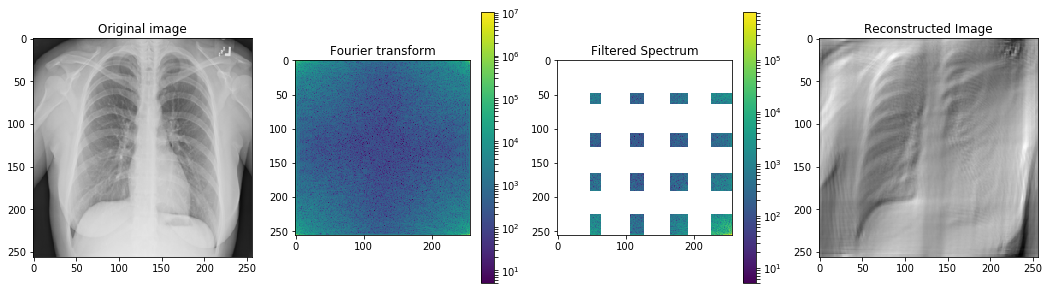

In [483]:
from scipy import fftpack
im_fft = fftpack.fft2(img)

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

keep_fraction = 0.0625
im_fft2 = im_fft.copy()
r, c = im_fft2.shape
for s in range(4):
    im_fft2[int(s*r*keep_fraction*4):int((s*4+3-0.3*s)*r*keep_fraction)] = 0
    im_fft2[:, int(s*c*keep_fraction*4):int((s*4+3-0.3*s)*c*keep_fraction)] = 0

fig = plt.figure(figsize = (18,5))

ax1 = fig.add_subplot(1,4,1)
ax1.set_title('Original image')
plt.imshow(img, plt.cm.gray)


ax2 = fig.add_subplot(1,4,2)
ax2.set_title('Fourier transform')
plot_spectrum(im_fft)

ax3 = fig.add_subplot(1,4,3)
ax3.set_title('Filtered Spectrum')
plot_spectrum(im_fft2)

im_new = fftpack.ifft2(im_fft2).real
ax3 = fig.add_subplot(1,4,4)
ax3.set_title('Reconstructed Image')
plt.imshow(im_new, plt.cm.gray)


In [551]:
def fft_filtered(image_name):
    file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
    img = Image.open(file_path+image_name)
    im_fft = fftpack.fft2(img)
    keep_fraction = 0.0625
    im_fft2 = im_fft.copy()
    r, c = im_fft2.shape
    for s in range(4):
        im_fft2[int(s*r*keep_fraction*4):int((s*4+3-0.3*s)*r*keep_fraction)] = 0
        im_fft2[:, int(s*c*keep_fraction*4):int((s*4+3-0.3*s)*c*keep_fraction)] = 0
    fft_vec = im_fft2.reshape(-1)
    fft_vec = fft_vec[np.nonzero(fft_vec)]
    return np.concatenate((fft_vec.real, fft_vec.imag), axis=None)

In [552]:
cnt = 0
fft_vec_list = []
start_time = time.time()
for image_name in new_df['Image Index'].values:
    fft_vec_list += [fft_filtered(image_name)]
    cnt += 1
    if cnt % 10 == 0:
        clear_output()
        print('{} % done! {:2f}s cost!'.format(cnt/len(new_df['Image Index'].values)*100,time.time()-start_time))

99.8719590268886 % done! 8.044641s cost!


In [553]:
X_fft = np.array(fft_vec_list)
Idx_fft = np.arange(len(X_fft))
np.random.shuffle(Idx_fft)
idx_fft, idx_test_fft = Idx_fft[:1400], Idx_fft[1400:]

x_sample_fft = X_fft[idx_fft]
x_test_fft = X_fft[idx_test_fft]

In [575]:
def KNN_fft(desease_type):
    y_fft = one_hot_df[desease_type].values
    y_sample_fft = y_fft[idx_fft]
    y_test_fft = y_fft[idx_test_fft]

    nbrs_fft = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree',weights = 'distance')

    nbrs_fft.fit(x_sample_fft,y_sample_fft) 
    x_predict_fft = nbrs_fft.predict(x_test_fft)
    accuracy = sum([1 if y_test_fft[i] == x_predict_fft[i] else 0 for i in range(len(x_predict_fft))]) / len(x_predict_fft)
    print('Accuracy for {} is {:2f}'.format(desease_type,accuracy))
    return accuracy

In [576]:
fft_knn_accruacy = [KNN_fft(desease_type) for desease_type in desease_types]

Accuracy for Atelectasis is 0.981481
Accuracy for Cardiomegaly is 0.987654
Accuracy for Consolidation is 1.000000
Accuracy for Edema is 1.000000
Accuracy for Effusion is 0.969136
Accuracy for Emphysema is 0.987654
Accuracy for Fibrosis is 0.993827
Accuracy for Hernia is 1.000000
Accuracy for Infiltration is 0.901235
Accuracy for Mass is 0.969136
Accuracy for No Finding is 0.697531
Accuracy for Nodule is 0.962963
Accuracy for Pleural_Thickening is 0.975309
Accuracy for Pneumonia is 1.000000
Accuracy for Pneumothorax is 0.969136


Gabor stats KNN

Here is a KNN classifier based on the gabor stats, which we had high expectation on the 'No Finding' label. 

In [14]:
X_gabor = np.array(gabor_stats)
Idx_gabor = np.arange(len(X_gabor))
np.random.shuffle(Idx_gabor)
idx_gabor, idx_test_gabor = Idx_gabor[:1400], Idx_gabor[1400:]

x_sample_gabor = X_gabor[idx_gabor]
x_test_gabor = X_gabor[idx_test_gabor]
desease_types = list(one_hot_df)[1:]

In [22]:
def KNN_gabor(desease_type):
    y_gabor = one_hot_df[desease_type].values
    y_sample_gabor = y_gabor[idx_gabor]
    y_test_gabor = y_gabor[idx_test_gabor]

    nbrs_gabor = KNeighborsClassifier(n_neighbors=20, algorithm='ball_tree',weights = 'distance')

    nbrs_gabor.fit(x_sample_gabor,y_sample_gabor) 
    x_predict_gabor = nbrs_gabor.predict(x_test_gabor)
    accuracy = sum([1 if y_test_gabor[i] == x_predict_gabor[i] else 0 for i in range(len(x_predict_gabor))]) / len(x_predict_gabor)
    print('Accuracy for {} is {:2f}'.format(desease_type,accuracy))
    return accuracy

In [23]:
gabor_knn_accruacy = [KNN_gabor(desease_type) for desease_type in desease_types]

Accuracy for Atelectasis is 0.962963
Accuracy for Cardiomegaly is 1.000000
Accuracy for Consolidation is 0.987654
Accuracy for Edema is 1.000000
Accuracy for Effusion is 0.962963
Accuracy for Emphysema is 0.987654
Accuracy for Fibrosis is 0.993827
Accuracy for Hernia is 1.000000
Accuracy for Infiltration is 0.851852
Accuracy for Mass is 0.969136
Accuracy for No Finding is 0.623457
Accuracy for Nodule is 0.969136
Accuracy for Pleural_Thickening is 0.962963
Accuracy for Pneumonia is 0.993827
Accuracy for Pneumothorax is 0.969136


In [27]:
['Percent for {} in test data is {:2f}'.format(desease_type,max(sum(one_hot_df[desease_type].values[idx_test_gabor])/len(idx_test_gabor),1-sum(one_hot_df[desease_type].values[idx_test_gabor])/len(idx_test_gabor))) for desease_type in desease_types]

['Percent for Atelectasis in test data is 0.962963',
 'Percent for Cardiomegaly in test data is 1.000000',
 'Percent for Consolidation in test data is 0.987654',
 'Percent for Edema in test data is 1.000000',
 'Percent for Effusion in test data is 0.962963',
 'Percent for Emphysema in test data is 0.987654',
 'Percent for Fibrosis in test data is 0.993827',
 'Percent for Hernia in test data is 1.000000',
 'Percent for Infiltration in test data is 0.851852',
 'Percent for Mass in test data is 0.969136',
 'Percent for No Finding in test data is 0.611111',
 'Percent for Nodule in test data is 0.969136',
 'Percent for Pleural_Thickening in test data is 0.962963',
 'Percent for Pneumonia in test data is 0.993827',
 'Percent for Pneumothorax in test data is 0.969136']